In [2]:
import os, shutil, random
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import random
from keras.models import Model
from keras.layers import Input,MaxPooling2D,UpSampling2D,Conv2DTranspose,Conv2D
from keras.layers import concatenate,BatchNormalization,Dropout,Lambda
from keras import backend as K
import tensorflow as tf
import albumentations as A
from albumentations.core.composition import OneOf

In [ ]:
!pip install -U segmentation-models

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install segmentation-models-pytorch torch torchvision albumentations==1.3.1

In [6]:
image_dir = "/content/drive/MyDrive/rooftop_dataset/train/images/"   # original images
mask_dir = "/content/drive/MyDrive/rooftop_dataset/train/masks/"
val_image_dir="/content/drive/MyDrive/rooftop_dataset/val/images/"
val_mask_dir="/content/drive/MyDrive/rooftop_dataset/val/masks/"

In [7]:
image=cv2.imread(f'{image_dir}/tile_img_0_5.png',1)

In [8]:
image.shape

(256, 256, 3)

In [9]:
for id in range(1,10):
  image=cv2.imread(f'{image_dir}/tile_img_0_{id}.png',1)
  mask=cv2.imread(f'{mask_dir}/tile_mask_0_{id}.png',1)
  print(type(mask))
 # print(image.shape)
 # print(mask.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
mask.dtype

dtype('uint8')

In [11]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.7, border_mode=cv2.BORDER_REFLECT),

    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.GaussianBlur()
    ], p=0.3),
], p=1.0)

# Function to apply the transforms to an image and its corresponding mask
def augment(image, mask):
    augmented = train_transform(image=image, mask=mask)
    image_aug = augmented['image']
    mask_aug = augmented['mask']
    return image_aug, mask_aug

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
/tmp/ipython-input-4039001437.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),


In [12]:
AUGMENT_TIMES = 5

In [13]:
import os
import cv2

image_dataset, mask_dataset = [], []
val_images, val_masks = [], []
train_labels = []

img_dir = "/content/drive/MyDrive/rooftop_dataset/train/images/"
mask_dir = "/content/drive/MyDrive/rooftop_dataset/train/masks/"
val_image_dir = "/content/drive/MyDrive/rooftop_dataset/val/images/"
val_mask_dir  = "/content/drive/MyDrive/rooftop_dataset/val/masks/"


image_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(".png")])
mask_files  = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(".png")])
val_image_files = sorted([f for f in os.listdir(val_image_dir) if f.lower().endswith(".png")])
val_mask_files  = sorted([f for f in os.listdir(val_mask_dir) if f.lower().endswith(".png")])


for img_file, mask_file in zip(image_files, mask_files):
    img_path  = os.path.join(img_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    img  = cv2.imread(img_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

   # img,mask = augment(img, mask)

    image_dataset.append(img)
    mask_dataset.append(mask)

    label = (mask == 0).astype("uint8")  # black=1, white=0
    label = np.expand_dims(label, axis=-1)
    train_labels.append(label)

    for _ in range(AUGMENT_TIMES):
        img_aug, mask_aug = augment(img, mask)
        img_aug=img_aug/255.0
        mask_aug=mask_aug/255.0
        image_dataset.append(img_aug)#
        mask_dataset.append(mask_aug)
        label = (mask_aug == 0).astype("uint8")   # black=1, white=0
        label = np.expand_dims(label, axis=-1)
        train_labels.append(label)
        #train_labels.append(label)

# validation loop
for val_image_file, val_mask_file in zip(val_image_files, val_mask_files):
    val_img_path  = os.path.join(val_image_dir, val_image_file)
    val_mask_path = os.path.join(val_mask_dir, val_mask_file)

    val_img  = cv2.imread(val_img_path, cv2.IMREAD_COLOR)
    val_mask = cv2.imread(val_mask_path, cv2.IMREAD_GRAYSCALE)
    val_img  = val_img / 255.0
    val_mask = val_mask / 255.0

    val_images.append(val_img)
    val_masks.append(val_mask)

print("Training images:", len(image_dataset))
print("Training masks:", len(mask_dataset))
print("Validation images:", len(val_images))
print("Validation masks:", len(val_masks))
print("Train labels shape:", len(train_labels))


Training images: 720
Training masks: 720
Validation images: 49
Validation masks: 49
Train labels shape: 720


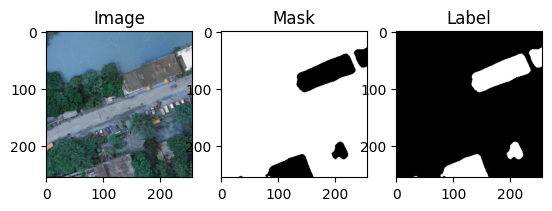

In [14]:
import matplotlib.pyplot as plt


idx = 0

plt.subplot(1, 3, 1)
plt.imshow(image_dataset[idx])
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(mask_dataset[idx], cmap='gray')
plt.title('Mask')

plt.subplot(1, 3, 3)
plt.imshow(train_labels[idx].squeeze(), cmap='gray')
plt.title('Label')

plt.show()


In [15]:
mismatch_indices = []
for i in range(len(image_dataset)):
    mask = mask_dataset[i]
    label = train_labels[i].squeeze()
    if not np.array_equal(label, (mask == 0).astype(np.uint8)):
        mismatch_indices.append(i)

if not mismatch_indices:
    print("All masks and labels match")
else:
    print("Mismatch at indices:", mismatch_indices)


All masks and labels match


In [16]:
image_dataset=np.array(image_dataset)
mask_dataset=np.array(mask_dataset)
train_labels=np.array(train_labels)


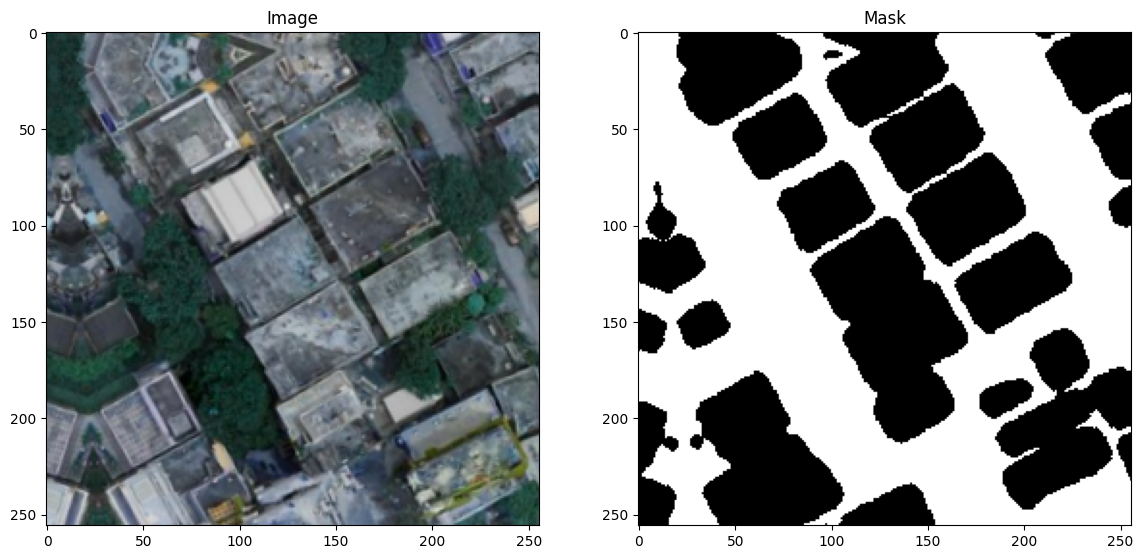

In [17]:
random_id=random.randint(0,len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_id])
plt.title("Image")
plt.subplot(1,2,2)
plt.imshow(mask_dataset[random_id], cmap="gray")
plt.title("Mask")
plt.show()


In [18]:
import os
import cv2
import numpy as np





val_image_dir = "/content/drive/MyDrive/rooftop_dataset/val/images/"
val_mask_dir  = "/content/drive/MyDrive/rooftop_dataset/val/masks/"

val_image_files = sorted(os.listdir(val_image_dir))
val_mask_files  = sorted(os.listdir(val_mask_dir))

val_images, val_labels = [], []

for img_file, mask_file in zip(val_image_files, val_mask_files):
    img_path  = os.path.join(val_image_dir, img_file)
    mask_path = os.path.join(val_mask_dir, mask_file)


    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    val_images.append(img)


    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask=mask/255.0
    label = (mask == 0).astype("uint8")   # black=1, white=0
    val_labels.append(label)

val_images = np.array(val_images)
val_labels = np.expand_dims(np.array(val_labels), -1)

print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)


Validation images shape: (49, 256, 256, 3)
Validation labels shape: (49, 256, 256, 1)


In [19]:
X_train=image_dataset
X_test=val_images
y_train=train_labels
y_test=val_labels

In [20]:
y_train=np.array(y_train)
X_test=np.array(X_test)


In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(720, 256, 256, 3)
(49, 256, 256, 3)
(720, 256, 256, 1)
(49, 256, 256, 1)


In [22]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [23]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
1


In [24]:
def jaccard_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_flatten = tf.reshape(y_true, [-1])
    y_pred_flatten = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (
        tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) - intersection + 1.0
    )
    return final_coef_value



In [25]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


In [26]:
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

In [27]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(1, (1,1), activation="sigmoid")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [28]:
metrics = ["accuracy", jaccard_coef]

In [29]:
loss=[combined_loss]

In [30]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [31]:
model = get_deep_learning_model()

In [32]:
#model.get_config()

In [33]:
tf.keras.backend.clear_session()

In [34]:
from tensorflow.keras.losses import binary_crossentropy

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=loss, metrics=metrics)

In [36]:
#model.summary()

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [ ]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,
                          validation_data=(X_test, y_test),
                          callbacks=[early_stopping_callback],
                          shuffle=True)

In [ ]:
history_a = model_history

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model_history.params

In [ ]:
x=cv2.imread("/content/drive/MyDrive/rooftop_dataset/y/tile_img_0_1.png")

In [ ]:
x_input=np.expand_dims(x,axis=0)
x_input.shape

In [ ]:
y_pred = model.predict(x_input)